##### Copyright 2023 Melchor Lafuente Duque

# FILTERING THE SIGNAL

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import scipy.io.wavfile as wavfile
import scipy.fftpack as sp
import scipy.signal as s
import cupy as cp
from PIL import Image
import imageio.v2 as imageio
import os

# Functions to read and write wav, txt and npy files

In [2]:
def read_wav(file_name, dir_name_input = "INPUT"):
    file_location = join(dir_name_input, file_name + ".wav")
    sample_rate, signal = wavfile.read(file_location)
    
    # If the signal is stereo, we transform it to mono:
    if signal.ndim > 1:
        left_channel = signal[:, 0]
        right_channel = signal[:, 1]
        signal = np.mean([left_channel, right_channel], axis=0)   
        
    return sample_rate, signal

def write_wav(file_name, sr, signal, output_dir_name = "OUTPUT"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    file_name_output = os.path.join(output_path, file_name + ".wav")
    wavfile.write(file_name_output, sr, signal.astype('int16'))

In [3]:
def write_txt(output_dir_name, signal_name, filename, data, data_type = '%d'):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".txt")
    np.savetxt(filename_output, [data], fmt = data_type)

In [4]:
def write_npy(output_dir_name, signal_name, filename, data):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, signal_name + "_" + filename + ".npy")
    np.save(filename_output, data)

## Plotting functions

We define the GPU device that we are going to use, in my case, I have three devices that I could use. So I will use one that is not being used by the previous process, the number three for example:

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3" #0,1,2,3

We define functions to plot the signals:

In [6]:
def plot_signal(sr, signal, file_name, file_suffix = "wav"):
    # Compute time axis in seconds
    time = np.arange(len(signal)) / float(sr)
    duration = time.max()

    # Plot audio signal
    fig, ax = plt.subplots()

    ax.plot(time, signal)
    
    # Add a title and axis labels
    file_location = join(file_name + "." + file_suffix)
    
    ax.set_title(file_location)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude (A)")

    plt.show()

## Reconstructed signal:

We will be using the following sample rate:

In [7]:
sample_rate = np.loadtxt(join("OUTPUT_2/ORIGIN", "ORIGINAL_sample_rate.txt"), dtype=int)

And first, we'll analyze the signal obtained from the grey image:

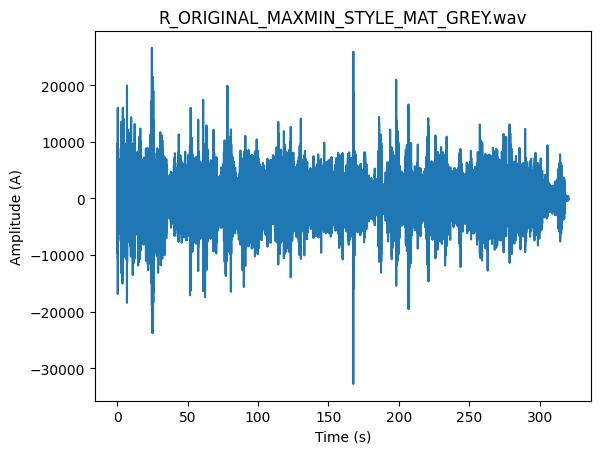

In [8]:
sample_rate_GREY, r_signal_GREY = read_wav(file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_GREY", dir_name_input = "OUTPUT_4")
plot_signal(sample_rate_GREY, r_signal_GREY, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_GREY", file_suffix = "wav")

Later, we are going to work with the signals obtained from the blue, green and red channels to process them independently, trying to subtract more information than when working with the signal obtained from the gray image in the previous process:

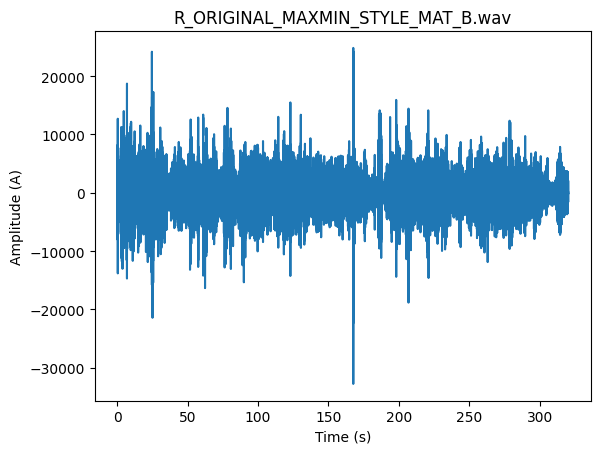

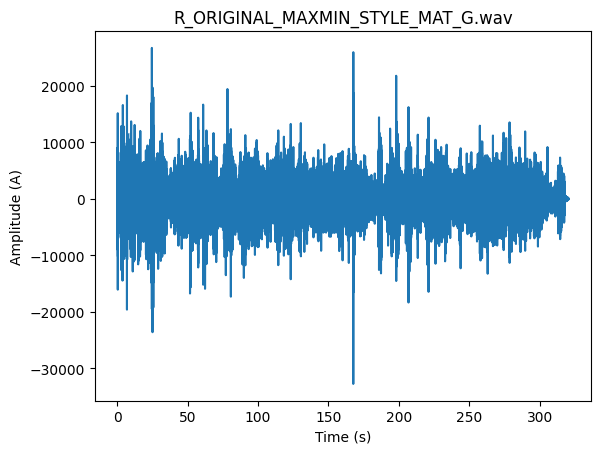

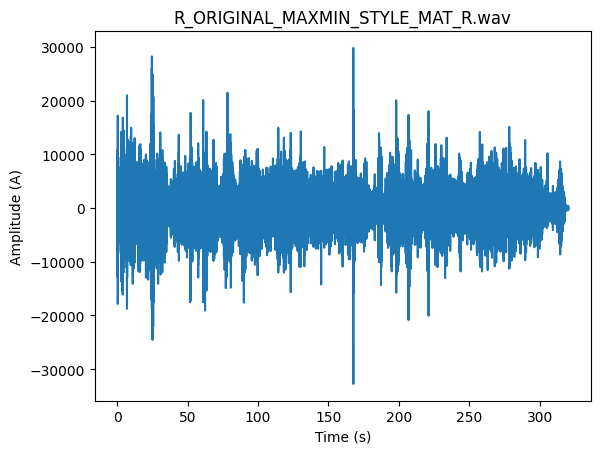

In [9]:
sample_rate_B, r_signal_B = read_wav(file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_B", dir_name_input = "OUTPUT_4")
plot_signal(sample_rate_B, r_signal_B, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_B", file_suffix = "wav")

sample_rate_G, r_signal_G = read_wav(file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_G", dir_name_input = "OUTPUT_4")
plot_signal(sample_rate_G, r_signal_G, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_G", file_suffix = "wav")

sample_rate_R, r_signal_R = read_wav(file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_R", dir_name_input = "OUTPUT_4")
plot_signal(sample_rate_R, r_signal_R, file_name = "R_ORIGINAL_MAXMIN_STYLE_MAT_R", file_suffix = "wav")

We will store these three signals in a dictionary, a list and an array:

In [10]:
# Dictionary
BGR_signals_dict = dict([('B', r_signal_B), ('G', r_signal_G), ('R', r_signal_R)])

# List
BGR_signals_list = []
for key in BGR_signals_dict:
    BGR_signals_list.append(BGR_signals_dict[key]) 
    
# Array
BGR_signals_array = np.array(BGR_signals_list)

## Correlation and Squared Error

The **cross-correlation** is a measure of similarity between two signals based on their overlap and relative displacement. Thus, we are going to use this the measure to quantify how good the reconstructions are, comparing the original and style audios with the different reconstructions: 

In [11]:
def correlation_normalized(signal_1, signal_2):
    signal_1_f = signal_1.astype('float64')
    signal_2_f = signal_2.astype('float64')
    
    x_gpu = cp.asarray(signal_1_f)
    y_gpu = cp.asarray(signal_2_f)
    
    corr_gpu = cp.correlate(x_gpu, y_gpu, mode='valid')
    corr_np = cp.asnumpy(corr_gpu)
    
    return corr_np/np.sqrt(np.sum(np.square(signal_1_f)) * np.sum(np.square(signal_2_f)))

<br>If the correlation is 1 then the signals are exactly the same, if the correlation is -1, then, the signals are exactly opposite to each other. We'll be using the following audio signals to compare how good our reconstructions are:
<br>
<br>

In [12]:
_ , original_signal = read_wav(file_name = "ORIGINAL_PROCESED", dir_name_input = "OUTPUT_1")
_ , style_signal = read_wav(file_name = "STYLE_PROCESED", dir_name_input = "OUTPUT_1")

So, if we check the correlation between these signals and the reconstructed audio from the grey image we have the following results:

In [13]:
corr_original_GREY = correlation_normalized(r_signal_GREY, original_signal)
corr_style_GREY = correlation_normalized(r_signal_GREY, style_signal)

print("\nCorrelation between the original song and the filtered GREY signal: ", corr_original_GREY)
print("Correlation between the style song and the filtered  GREY  signal : ", corr_style_GREY)


Correlation between the original song and the filtered GREY signal:  [0.00218254]
Correlation between the style song and the filtered  GREY  signal :  [0.3640425]


As might be expected, these signals tend to be more like the style song. This is due to the matrix of signs used to reconstruct the audios, as we explained in the previous point `4_Processing_image_to_audio`. Anyway, what would happen if we use some bandpass filters with the audio obtained from the GREY image? Would them help to improve the correlations? Let's see:

## Obtaining different frequency domains

Since human perception is only capable of hearing frequencies between 20 Hz and 20 KHz, we can try applying some bandpass filters. By this way, maybe we avoid some noise that could have been created during the IDCT.
<br>
<br>
Even if we will use cross-correlation to check if the audio quality improves, it should be noted that letting ourselves be guided solely and exclusively by what the numbers tell us may not turn out to be a very successful practice and we should also be guided by our own auditory perception. Anyway, let's create two functions to make the bandpass filters possible:

In [14]:
def obtain_filters(sample_rate, freqs, N = 4):
    low_freq, high_freq = freqs
    nyquist_freq = 0.5 * sample_rate 

    #Cutoff frequencies bellow low_freq
    low_cutoff_freq = low_freq / nyquist_freq

    #Cutoff frequencies over high_freq
    high_cutoff_freq = high_freq / nyquist_freq

    b, a = s.butter(N, [low_cutoff_freq, high_cutoff_freq], 'bandpass')
    return b, a

def filter_signal(b, a, signal):
    return s.filtfilt(b, a, signal).astype("int16")

Now, we can filter the reconstructed signal, applying bandpass filters to see in which frequencies it has more information:

In [15]:
# https://www.headphonesty.com/2020/02/audio-frequency-spectrum-explained/
AF = dict([('sub_bass',[16, 60]),('bass',[60,250]),('low_mids',[250,500]),('mids',[500, 2000]),('high_mids',[2000,4000]),('presence',[4000,6000]),('brillance',[6000,20000])]) #audible frequencies  

So, we first filter the signals we'll be using to check the quality of the ones we really want to filter:

In [16]:
original_signals = []
style_signals = []

for freq in AF:
    
    b, a = obtain_filters(sample_rate, AF[freq], N = 3)
    
    filtered_original_signal_sfq = filter_signal(b, a, original_signal) # sfq = sub frequencies
    filtered_style_signal_sfq = filter_signal(b, a, style_signal) # sfq = sub frequencies
    
    original_signals.append(filtered_original_signal_sfq)
    style_signals.append(filtered_style_signal_sfq)

And then we subtract the different subgroups of frequencies from the `r_signal_GREY` signal as well as the correlation between these subsignals and those obtained from the original and style audios:

In [17]:
r_signal_GREY_sfqs = []
corrs_original_GREY = []
corrs_style_GREY = []

for (i,freq) in enumerate(AF):

    b, a = obtain_filters(sample_rate, AF[freq], N = 3)
    filtered_reconstructed_signal_sfq = filter_signal(b, a, r_signal_GREY) # sfq = sub frequencies

    r_signal_GREY_sfqs.append(filtered_reconstructed_signal_sfq)

    corr_original = correlation_normalized(original_signals[i], filtered_reconstructed_signal_sfq)[0]
    corrs_original_GREY.append(corr_original)

    corr_style = correlation_normalized(style_signals[i], filtered_reconstructed_signal_sfq)[0]
    corrs_style_GREY.append(corr_style)

    print(str(freq) + " | Original: [", round(corr_original,4), "] Style: [", round(corr_style,4),"]\n")

sub_bass | Original: [ 0.0036 ] Style: [ 0.2628 ]

bass | Original: [ 0.0039 ] Style: [ 0.3939 ]

low_mids | Original: [ 0.003 ] Style: [ 0.4645 ]

mids | Original: [ 0.002 ] Style: [ 0.4247 ]

high_mids | Original: [ -0.0006 ] Style: [ 0.3971 ]

presence | Original: [ -0.0012 ] Style: [ 0.3746 ]

brillance | Original: [ -0.0012 ] Style: [ 0.3545 ]



At this point we can add our own criteria for selecting only some sub-frequency groups. So, let's choose only those that have a positive correlation with the original song:

In [18]:
filtered_sfqs_GREY = np.where(((np.array(corrs_original_GREY) > 0)))[0]

So now we know the following information:

In [19]:
filtered_GREY = np.array(r_signal_GREY_sfqs)[filtered_sfqs_GREY].sum(axis = 0)

corr_original_GREY_FILTERED = correlation_normalized(filtered_GREY, original_signal)
corr_style_GREY_FILTERED = correlation_normalized(filtered_GREY, style_signal)

print("\n\nCorrelation between the original song and the GREY signal: ", np.round(corr_original_GREY, 4))
print("Correlation between the style song and the  GREY  signal : ", np.round(corr_style_GREY, 4),"\n")

print("Correlation between the original song and the FILTERED GREY signal: ", np.round(corr_original_GREY_FILTERED, 4))
print("Correlation between the style song and the FILTERED  GREY  signal : ", np.round(corr_style_GREY_FILTERED, 4),"\n")



Correlation between the original song and the GREY signal:  [0.0022]
Correlation between the style song and the  GREY  signal :  [0.364] 

Correlation between the original song and the FILTERED GREY signal:  [0.0026]
Correlation between the style song and the FILTERED  GREY  signal :  [0.3552] 



While we've improved the correlation between this signal and the original song by filtering out subfrequencies that had any relationship to the original song, we've lost correlation between the reconstructed signal and the style song. That is, we cannot improve a correlation without negatively affecting the other using the GREY signal. The question then is whether we want to improve any of the correlations, and if so, apply the process described above. Anyway, let's save the resulting filtered signal:

In [20]:
write_wav("GREY_SIGNAL_FILTERED", sample_rate, filtered_GREY, output_dir_name = "OUTPUT_5")

## RGB CHANNELS

We can now analyze the BGR channels to try to substract more information. Let's see then if the signals of the channels are different from each other. If so, this means that they provide different information:

In [21]:
corr_BG = correlation_normalized(r_signal_B, r_signal_G)
corr_BR = correlation_normalized(r_signal_B, r_signal_R)
corr_GR = correlation_normalized(r_signal_G, r_signal_R)

print("\n\nBLUE-GREEN: ", np.round(corr_BG, 4))
print("BLUE-RED: ", np.round(corr_BR, 4))
print("GREEN-RED: ", np.round(corr_GR, 4))



BLUE-GREEN:  [0.8355]
BLUE-RED:  [0.8462]
GREEN-RED:  [0.9559]


Indeed, each color channel seems to provide different information. Now let's see if these signals are anything like the original song they were created from or if they are similar to the style song we wanted them to follow.

In [22]:
corr_with_original_B = correlation_normalized(original_signal, r_signal_B)
corr_with_style_B = correlation_normalized(style_signal, r_signal_B)

corr_with_original_G = correlation_normalized(original_signal, r_signal_G)
corr_with_style_G = correlation_normalized(style_signal, r_signal_G)

corr_with_original_R = correlation_normalized(original_signal, r_signal_R)
corr_with_style_R = correlation_normalized(style_signal, r_signal_R)

print("\n\nBLUE: Original", np.round(corr_with_original_B, 4), "Style", np.round(corr_with_style_B, 4))
print("GREEN: Original", np.round(corr_with_original_G, 4), "Style", np.round(corr_with_style_G, 4))
print("RED: Original", np.round(corr_with_original_R, 4), "Style", np.round(corr_with_style_R, 4))



BLUE: Original [0.0016] Style [0.3375]
GREEN: Original [0.0023] Style [0.3552]
RED: Original [0.002] Style [0.3537]


Next, let's combine the signals as follows:

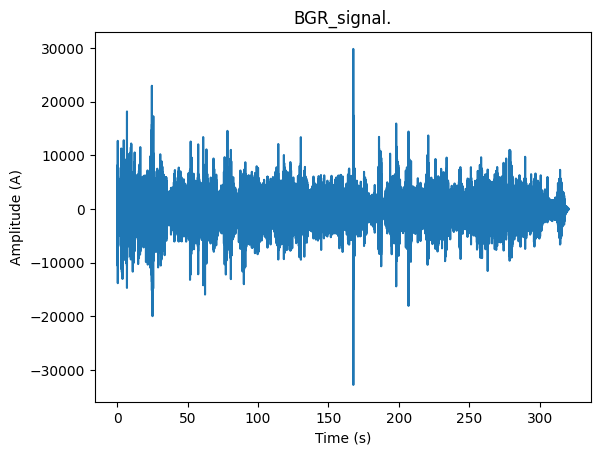

In [23]:
BGR_signal = np.zeros(len(BGR_signals_dict['B']))

for i in range(len(BGR_signal)):
    if BGR_signals_array[:,i].sum() >= 0:
        BGR_signal[i] = np.min(BGR_signals_array[:,i])
    else:
        BGR_signal[i] = np.max(BGR_signals_array[:,i])

plot_signal(sample_rate, BGR_signal, "BGR_signal", file_suffix = "")

So their correlations are:

In [24]:
corr_BGR_original = correlation_normalized(original_signal, BGR_signal) 
corr_BGR_style = correlation_normalized(style_signal, BGR_signal)

print("\nBGR: Original", np.round(corr_BGR_original, 4), "Style", np.round(corr_BGR_style, 4))


BGR: Original [0.0021] Style [0.3622]


Since, GREY signal's correlations were:

In [25]:
print("\nGREY: Original", np.round(corr_original_GREY, 4), "Style",np.round(corr_style_GREY, 4))


GREY: Original [0.0022] Style [0.364]


In this way, we observe that BGR signal give worse results than the GREY signal. But what happens if we try to improve these results with bandpass filters? 
<br>
<br>
Let's apply the bandpass filtering process to the BGR signals indepently to combine them later.

In [26]:
r_signals_sfq =  dict([('B', []), ('G', []), ('R', [])])
corrs_original =  dict([('B', []), ('G', []), ('R', [])])
corrs_style =  dict([('B', []), ('G', []), ('R', [])])

for channel in r_signals_sfq:
    for (i,freq) in enumerate(AF):

        b, a = obtain_filters(sample_rate, AF[freq], N = 3)
        filtered_reconstructed_signal_sfq = filter_signal(b, a, BGR_signals_dict[channel]) # sfq = sub frequencies

        r_signals_sfq[channel].append(filtered_reconstructed_signal_sfq)
        
        corr_original = correlation_normalized(original_signals[i], filtered_reconstructed_signal_sfq)[0]
        corrs_original[channel].append(corr_original)
        
        corr_style = correlation_normalized(style_signals[i], filtered_reconstructed_signal_sfq)[0]
        corrs_style[channel].append(corr_style)
        
        print(channel + " " + str(freq) + " | Original:[", np.round(corr_original,4), "] Style: [", np.round(corr_style,4), "] \n")
    print("---------------------------------------------------------------\n")

B sub_bass | Original:[ 0.0032 ] Style: [ 0.253 ] 

B bass | Original:[ 0.0042 ] Style: [ 0.4095 ] 

B low_mids | Original:[ 0.0032 ] Style: [ 0.4818 ] 

B mids | Original:[ 0.0011 ] Style: [ 0.4442 ] 

B high_mids | Original:[ -0.0008 ] Style: [ 0.4144 ] 

B presence | Original:[ -0.0005 ] Style: [ 0.3845 ] 

B brillance | Original:[ -0.0007 ] Style: [ 0.2221 ] 

---------------------------------------------------------------

G sub_bass | Original:[ 0.0026 ] Style: [ 0.259 ] 

G bass | Original:[ 0.0037 ] Style: [ 0.3843 ] 

G low_mids | Original:[ 0.0033 ] Style: [ 0.4519 ] 

G mids | Original:[ 0.0021 ] Style: [ 0.4129 ] 

G high_mids | Original:[ -0.0006 ] Style: [ 0.3867 ] 

G presence | Original:[ -0.0012 ] Style: [ 0.3653 ] 

G brillance | Original:[ -0.0013 ] Style: [ 0.3402 ] 

---------------------------------------------------------------

R sub_bass | Original:[ 0.0047 ] Style: [ 0.2558 ] 

R bass | Original:[ 0.0039 ] Style: [ 0.3869 ] 

R low_mids | Original:[ 0.0023 ] S

As we did with the GREY signal, at this point we can add our own criteria for selecting only some sub-frequency groups. So, let's choose only those that have a positive correlation with the original song. We will store the identifiers of the frequency subsignals that pass our filter in the following dictionary:

In [27]:
filtered_sfq_groups =  dict([('B', np.array([])), ('G', np.array([])), ('R', np.array([]))])

Now we define our filter:

In [28]:
for channel in filtered_sfq_groups:
    filtered_sfq_groups[channel] = np.where((np.array(corrs_original[channel]) > 0))[0]# & (np.array(corrs_style[channel]) > 0.4))[0]

And we are going to combine the signals of each color channel that have passed the filter, obtaining three new signals, one for each color channel:


Channel B is now composed of: 
-----------------------------
sub_bass 
bass 
low_mids 
mids 




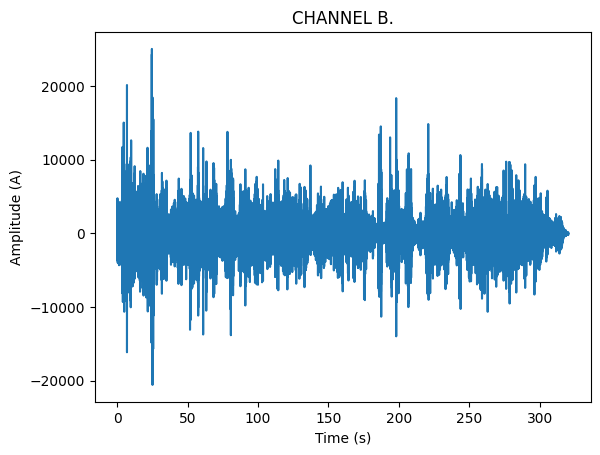


Channel G is now composed of: 
-----------------------------
sub_bass 
bass 
low_mids 
mids 




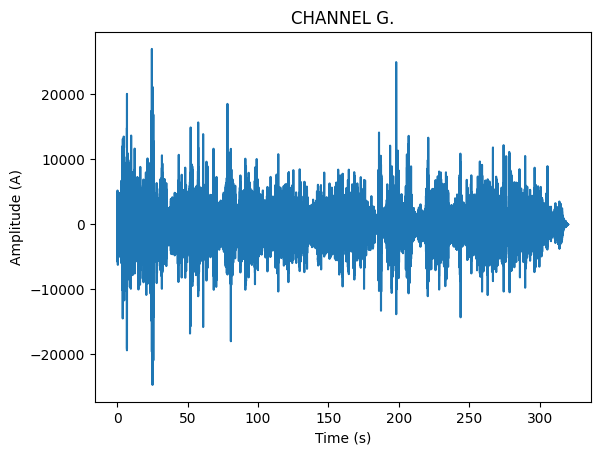


Channel R is now composed of: 
-----------------------------
sub_bass 
bass 
low_mids 
mids 




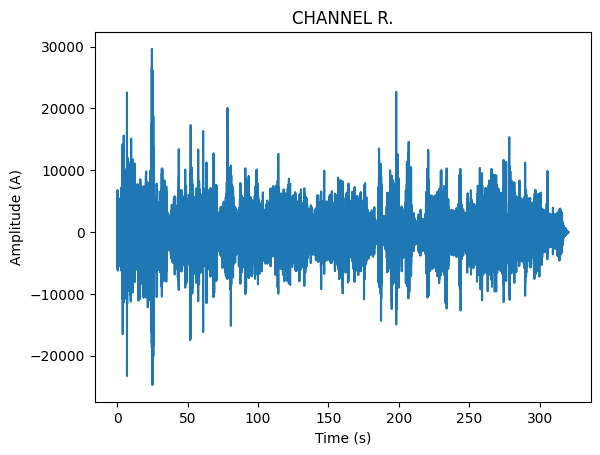

In [29]:
AF_keys = list(AF.keys())

final_signals = []
for channel in r_signals_sfq:
    sub_signals = np.array(r_signals_sfq[channel])[filtered_sfq_groups[channel]]
    
    channels_final_signal = np.zeros(len(sub_signals[0]))
    print("\nChannel " + channel + " is now composed of: ")
    print("-----------------------------")
    for i, signal in enumerate(sub_signals):
        channels_final_signal += signal
        print(AF_keys[filtered_sfq_groups[channel][i]] + " ")
    print("\n")
    final_signals.append(channels_final_signal)
    plot_signal(sample_rate, channels_final_signal, "CHANNEL " + channel, file_suffix = "")

Next, we'll combine the BGR signals:

In [30]:
BGR_signal_filtered = np.zeros(np.array(final_signals).shape[1])
final_signals_array = np.array(final_signals).copy()

for i in range(len(BGR_signal_filtered)):
    if final_signals_array[:,i].sum() >= 0:
        BGR_signal_filtered[i] = np.min(final_signals_array[:,i])
    else:
        BGR_signal_filtered[i] = np.max(final_signals_array[:,i])

So we have this two signals that used the BGR channels:

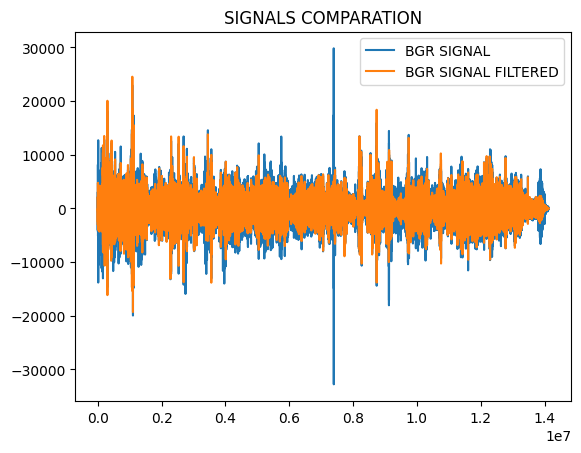

In [31]:
plt.title("SIGNALS COMPARATION")
plt.plot(range(len(BGR_signal)), BGR_signal, label = "BGR SIGNAL")
plt.plot(range(len(BGR_signal_filtered)), BGR_signal_filtered, label = "BGR SIGNAL FILTERED")
plt.legend()
plt.show()

If we take a look at all the correlations of interest that we have obtained, we have the following table of values:

In [32]:
corr_BGR_filtered_original = correlation_normalized(original_signal, BGR_signal_filtered)
corr_BGR_filtered_style = correlation_normalized(style_signal, BGR_signal_filtered)

print("SIGNALS FROM GREY IMAGE")
print("-----------------------")
print("1) NORMAL   | Original:", corr_original_GREY, "Style:", corr_style_GREY)
print("2) FILTERED | Original:",corr_original_GREY_FILTERED, "Style:", corr_style_GREY_FILTERED)
print()
print("SIGNALS FROM BGR IMAGE")
print("----------------------")
print("1) NORMAL   | Original:", corr_BGR_original, "Style:", corr_BGR_style)
print("2) FILTERED | Original:", corr_BGR_filtered_original, "Style:", corr_BGR_filtered_style)

SIGNALS FROM GREY IMAGE
-----------------------
1) NORMAL   | Original: [0.00218254] Style: [0.3640425]
2) FILTERED | Original: [0.0026167] Style: [0.35524267]

SIGNALS FROM BGR IMAGE
----------------------
1) NORMAL   | Original: [0.00208645] Style: [0.36219173]
2) FILTERED | Original: [0.0024177] Style: [0.36217411]


In conclusion and unlike with the signal obtained from the gray image, using the bandpass filters improves the correlation between the BGR signal and the original song without sacrificing too much correlation with the song style. So, according to the numbers, having worked with the BGR channels has turned out to be a good practice to try to improve the final audio. However, once again I would like to emphasize that it is important to listen to the results in order to select, according to human perception, the best audio.
<br>
<br>
Finally, let's save the signals obtained from the BGR images:

In [33]:
write_wav("BGR_SIGNAL", sample_rate, BGR_signal, output_dir_name = "OUTPUT_5")
write_wav("BGR_SIGNAL_FILTERED", sample_rate, BGR_signal_filtered, output_dir_name = "OUTPUT_5")